In [221]:
#Importing Libraries

import pandas as pd
import matplotlib.pyplot as plt
from numpy import mean, std
import numpy as np
import seaborn as sns
import re
import warnings
from sklearn.linear_model import LinearRegression,ridge_regression
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold
from scipy.stats import skew,kurtosis
from sklearn.preprocessing import StandardScaler

#Extra settings
pd.set_option('display.max_columns',None) # Will not truncate the display of columns 
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_rows',None) 
# np.set_printoptions(linewidth=10) 

In [222]:
#Loading train and test data
try:
    train_df=pd.read_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Dataset/train.csv')
    test_df=pd.read_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Dataset/test.csv')
    print("Train df shape: " ,train_df.shape)
    print("Test df shape: ", test_df.shape)

except FileNotFoundError:
    print("File not found")

Train df shape:  (1460, 81)
Test df shape:  (1459, 80)


In [223]:
#train
numeric_df=train_df.select_dtypes(include='number')
numeric_df_cols=[col for col in numeric_df.columns]

numeric_df_cols.remove('MSSubClass')
numeric_df_cols.remove('MoSold')

numeric_df_updated=numeric_df[numeric_df_cols]
numeric_df_saleprice=numeric_df_updated['SalePrice']
numeric_df_updated_train=numeric_df_updated.drop('SalePrice',axis=1)

#test

numeric_df_test=test_df.select_dtypes(include='number')
numeric_df_test_cols=[col for col in numeric_df_test.columns]
numeric_df_test_cols.remove('MSSubClass')
numeric_df_test_cols.remove('MoSold')

numeric_df_updated_test=test_df[numeric_df_test_cols]
numeric_df_updated_test=numeric_df_updated_test


In [224]:
#Removing Null
numeric_df_updated_train=numeric_df_updated_train.fillna(0)
numeric_df_updated_test=numeric_df_updated_test.fillna(0)

numeric_df_updated_train_Id=numeric_df_updated_train['Id']
numeric_df_updated_test_Id=numeric_df_updated_test['Id']
numeric_df_updated_train=numeric_df_updated_train.drop('Id',axis=1)
numeric_df_updated_test=numeric_df_updated_test.drop('Id',axis=1)


In [225]:
# combined_df_model1_df = pd.concat([train_df_numeric, test_df_numeric], axis=0, ignore_index=True)
numeric_df_updated_test.head(5)
print(numeric_df_updated_train.shape,numeric_df_updated_test.shape)

(1460, 34) (1459, 34)


In [226]:
#Create pipeline
rfe = RFE(estimator=LinearRegression(),n_features_to_select=1)
model=LinearRegression()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(pipeline, numeric_df_updated_train, numeric_df_saleprice, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Model 1:','MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Model 1: MAE: -33765.293 (2517.736)


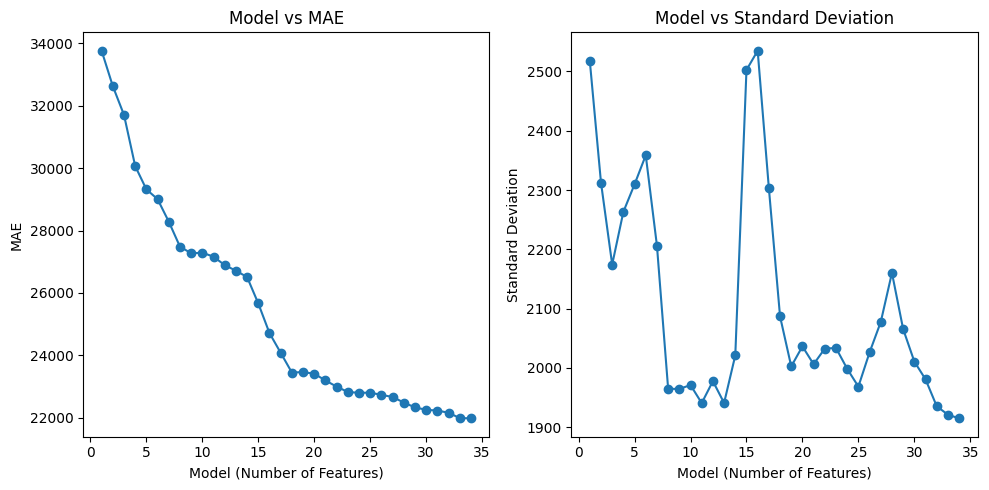

Around 15-20 features seems to be a good starting point. MAE has plateaued, and the standard deviation, while
not the absolute lowest, is relatively stable in this range.
Features beyond 20 offer minimal MAE improvement and come with more erratic standard deviation.
This suggests overfitting - the model might be picking up noise in the data rather than true patterns.



In [227]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold, cross_val_score
from numpy import mean, std

Final_col = [col for col in numeric_df_updated_train.columns]
selected_features_dict = {}  # Store selected features for each model
Final_eval=[]

for i in range(1, len(Final_col) + 1):
    # Create pipeline
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=i)
    model = LinearRegression()
    pipeline = Pipeline(steps=[('s', rfe), ('m', model)])

    # Evaluate model
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    n_scores = cross_val_score(pipeline, numeric_df_updated_train, numeric_df_saleprice, 
                                scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    
    # Fit the pipeline on all training data to get selected features
    pipeline.fit(numeric_df_updated_train, numeric_df_saleprice)
    selected_feature_indices = pipeline.named_steps['s'].support_
    selected_features = list(numeric_df_updated_train.columns[selected_feature_indices])
    selected_features_dict[i] = selected_features  # Store in the dictionary

    # Report performance
   # print(f'Model {i}: MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
    
    Final_eval.append({
        'Model': i,
        'MAE': -mean(n_scores),  # Negate to get positive MAE
        'Std Dev': std(n_scores),
        'Features': ', '.join(selected_features_dict[i])
    })

Final_eval_df=pd.DataFrame(Final_eval)

plt.figure(figsize=(10, 5))  # Adjust figure size as needed

# Plot Model vs MAE
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(Final_eval_df['Model'], Final_eval_df['MAE'], marker='o', linestyle='-')
plt.xlabel('Model (Number of Features)')
plt.ylabel('MAE')
plt.title('Model vs MAE')

# Plot Model vs Std Dev
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(Final_eval_df['Model'], Final_eval_df['Std Dev'], marker='o', linestyle='-')
plt.xlabel('Model (Number of Features)')
plt.ylabel('Standard Deviation')
plt.title('Model vs Standard Deviation')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


# # Print selected features for each model
# for i in range(1, len(Final_col) + 1):
#     print(f"Model {i} - Selected Features: {selected_features_dict[i]}")

print('Around 15-20 features seems to be a good starting point. MAE has plateaued, and the standard deviation, while\n\
not the absolute lowest, is relatively stable in this range.\n\
Features beyond 20 offer minimal MAE improvement and come with more erratic standard deviation.\n\
This suggests overfitting - the model might be picking up noise in the data rather than true patterns.\n')



In [228]:
#Features to use
Final_eval_df[Final_eval_df['Model']==20]

,Model,MAE,Std Dev,Features
19,20,23408.318669,2036.276027,"LotFrontage, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, 1stFlrSF, 2ndFlrSF, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageCars, ScreenPorch, PoolArea, YrSold"


In [229]:
#Benchmark model
model1=LinearRegression()
model1.fit(numeric_df_updated_train, numeric_df_saleprice)
y_pred_model1=model1.predict(numeric_df_updated_test)
y_pred_model1_df=pd.DataFrame(y_pred_model1)
y_pred_model1_df.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/model3.csv')

In [230]:
#Using 20 features 
Final_eval_df_20=Final_eval_df[Final_eval_df['Model']==20]
cols_from_RFE=list(Final_eval_df_20['Features'])
cols_from_RFE = cols_from_RFE[0].split(', ')
numeric_df_updated_train_20_feat=numeric_df_updated_train[cols_from_RFE]
numeric_df_updated_test_20_feat=numeric_df_updated_test[cols_from_RFE]

#model 2
model2=LinearRegression()
model2.fit(numeric_df_updated_train_20_feat, numeric_df_saleprice)
y_pred_model2=model2.predict(numeric_df_updated_test_20_feat)
y_pred_model2_df=pd.DataFrame(y_pred_model2)
y_pred_model2_df.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/model4.csv')

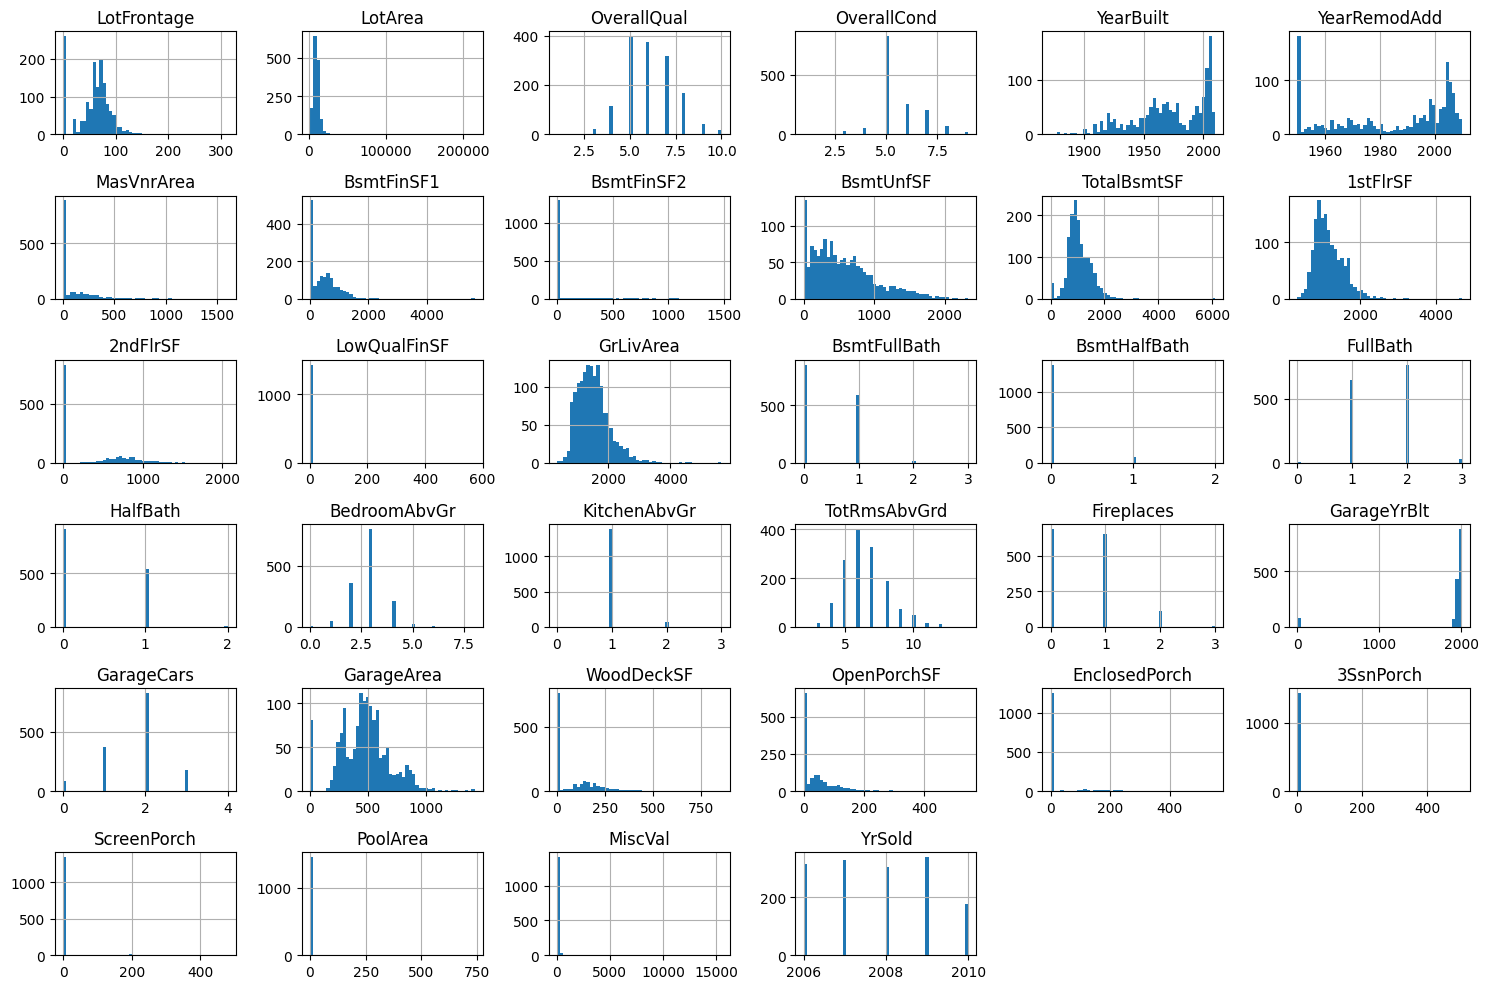

In [231]:
#Caculate skewness and kurtosis for all nuemrical cols on train data
skewness_values=numeric_df_updated_train.apply(skew)
kurtosis_values=numeric_df_updated_train.apply(kurtosis)

summary_df=pd.DataFrame({
    'Skewness':skewness_values,
    'kurtosis_values':kurtosis_values
},index=numeric_df_updated_train.columns)

#display(summary_df)

numeric_df_updated_train.hist(figsize=(15, 10), bins=50) 
plt.tight_layout()  # Prevent overlapping plots
plt.show() 

In [232]:
#train
display(summary_df[(summary_df['Skewness']>=0.5)])

,Skewness,kurtosis_values
LotArea,12.195142,202.543793
OverallCond,0.692355,1.098521
MasVnrArea,2.674865,10.102612
BsmtFinSF1,1.683771,11.076090
BsmtFinSF2,4.250888,20.040415
BsmtUnfSF,0.919323,0.469262
TotalBsmtSF,1.522688,13.201042
1stFlrSF,1.375342,5.722076
2ndFlrSF,0.812194,-0.555677
LowQualFinSF,9.002080,82.945932


In [233]:
#lets combine train and test 

combbined_train_test = pd.concat([numeric_df_updated_train, numeric_df_updated_test], axis=0, ignore_index=True)

skewness_values_combined=combbined_train_test.apply(skew)
kurtosis_values_combined=combbined_train_test.apply(kurtosis)

summary_df_combined=pd.DataFrame({
    'Skewness':skewness_values_combined,
    'kurtosis_values':kurtosis_values_combined
},index=combbined_train_test.columns)


In [234]:
#train and test combined
display(summary_df_combined[(summary_df_combined['Skewness']>=0.5)])

,Skewness,kurtosis_values
LotArea,12.822431,264.496632
OverallCond,0.570312,1.474860
MasVnrArea,2.613592,9.318376
BsmtFinSF1,1.425230,6.890172
BsmtFinSF2,4.146143,18.810079
BsmtUnfSF,0.919339,0.400758
TotalBsmtSF,1.156894,9.105153
1stFlrSF,1.469604,6.942514
2ndFlrSF,0.861675,-0.423593
LowQualFinSF,12.088761,174.631256


In [235]:
#Treating positive skewness with log transform

summary_df__comb_pos_skew=summary_df_combined[(summary_df_combined['Skewness']>=0.5)].index
summary_df__comb_pos_skew=list(summary_df__comb_pos_skew)

#first replace 0 values with 0.001 for log transform
combbined_train_test[summary_df__comb_pos_skew] = combbined_train_test[summary_df__comb_pos_skew].replace(0, 0.001)

# Apply the log1p transformation
combbined_train_test[summary_df__comb_pos_skew] = np.log1p(combbined_train_test[summary_df__comb_pos_skew]) 

In [236]:
#skewness after log transform
skewness_values_combined=combbined_train_test.apply(skew)
kurtosis_values_combined=combbined_train_test.apply(kurtosis)

summary_df_combined=pd.DataFrame({
    'Skewness':skewness_values_combined,
    'kurtosis_values':kurtosis_values_combined
},index=combbined_train_test.columns)
display(summary_df_combined[(summary_df_combined['Skewness']>=0.5)])

,Skewness,kurtosis_values
MasVnrArea,0.537057,-1.584828
BsmtFinSF2,2.462517,4.245770
LowQualFinSF,8.557755,72.187017
BsmtHalfBath,3.774978,12.578496
HalfBath,0.580850,-1.544736
KitchenAbvGr,3.523575,20.212512
EnclosedPorch,1.961111,1.970117
3SsnPorch,8.825296,76.451207
ScreenPorch,2.945917,6.749862
PoolArea,14.998370,223.932313


In [237]:
display(summary_df_combined[(summary_df_combined['Skewness']<=-0.5)])

,Skewness,kurtosis_values
LotArea,-0.504751,3.745614
OverallCond,-0.746183,6.131385
YearBuilt,-0.599806,-0.512497
BsmtFinSF1,-0.616589,-1.466150
BsmtUnfSF,-2.154996,3.949019
TotalBsmtSF,-4.956074,25.484034
GarageYrBlt,-3.906205,13.316886


In [238]:
summary_df__comb_neg_skew=summary_df_combined[(summary_df_combined['Skewness']<=-0.5)].index
summary_df__comb_neg_skew=list(summary_df__comb_neg_skew)
summary_df__comb_neg_skew

# #treating negative skewed data
# combbined_train_test[summary_df__comb_neg_skew] = np.sqrt(combbined_train_test[summary_df__comb_neg_skew] + 0.001) 

['LotArea',
 'OverallCond',
 'YearBuilt',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'GarageYrBlt']

In [239]:
# #skewness after log transform
# skewness_values_combined=combbined_train_test.apply(skew)
# kurtosis_values_combined=combbined_train_test.apply(kurtosis)

# summary_df_combined=pd.DataFrame({
#     'Skewness':skewness_values_combined,
#     'kurtosis_values':kurtosis_values_combined
# },index=combbined_train_test.columns)
# display(summary_df_combined[(summary_df_combined['Skewness']<=-0.5)])
# #Sqrt transform increased the skewness more so we wont use it

In [240]:
negatively_skewed_cols = ['LotArea', 'OverallCond', 'YearBuilt', 
                         'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 
                         'GarageYrBlt']

for col in negatively_skewed_cols:
    # 1. Reflection (Mirroring)
    max_val = combbined_train_test[col].max() + 1 # Adding 1 to avoid potential issues with 0
    combbined_train_test[col + '_reflected'] = max_val - combbined_train_test[col]

    #If all the values in a column are negative try to treat negative skewness using the following: Experiment with removing abs and with abs
    # col = 'col'
    # min_val = combbined_train_test[col].min() - 1
    # combbined_train_test[col + '_reflected'] = abs(min_val - combbined_train_test[col]) 

    # 2. Apply Transformation (e.g., Cube Root)
    combbined_train_test[col + '_cbrt'] = np.cbrt(combbined_train_test[col + '_reflected'])

In [241]:
combbined_train_test.head(5)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,LotArea_reflected,LotArea_cbrt,OverallCond_reflected,OverallCond_cbrt,YearBuilt_reflected,YearBuilt_cbrt,BsmtFinSF1_reflected,BsmtFinSF1_cbrt,BsmtUnfSF_reflected,BsmtUnfSF_cbrt,TotalBsmtSF_reflected,TotalBsmtSF_cbrt,GarageYrBlt_reflected,GarageYrBlt_cbrt
0,65.0,9.042040,7,1.791759,2003,2003,5.283204,6.561031,0.001,5.017280,6.753438,6.753438,6.751101,0.001,7.444833,0.693147,0.001000,2,0.693147,3,0.693147,2.197225,0.001000,2003.0,2.0,548.0,0.001000,4.127134,0.001000,0.001,0.001,0.001,0.001,2008,4.237497,1.618216,1.510826,1.147461,8,2.000000,3.077495,1.454563,3.739343,1.552143,2.964408,1.436523,205.0,5.896369
1,80.0,9.169623,6,2.197225,1976,1976,0.001000,6.886532,0.001,5.652489,7.141245,7.141245,0.001000,0.001,7.141245,0.001000,0.693147,2,0.001000,3,0.693147,1.945910,0.693147,1976.0,2.0,460.0,5.700444,0.001000,0.001000,0.001,0.001,0.001,0.001,2007,4.109914,1.601810,1.105361,1.033954,35,3.271066,2.751994,1.401358,3.104134,1.458748,2.576601,1.370931,232.0,6.144634
2,68.0,9.328212,7,1.791759,2001,2002,5.093750,6.188264,0.001,6.075346,6.825460,6.825460,6.765039,0.001,7.488294,0.693147,0.001000,2,0.693147,3,0.693147,1.945910,0.693147,2001.0,2.0,608.0,0.001000,3.761200,0.001000,0.001,0.001,0.001,0.001,2008,3.951325,1.580936,1.510826,1.147461,10,2.154435,3.450261,1.511068,2.681277,1.389251,2.892386,1.424794,207.0,5.915482
3,60.0,9.164401,7,1.791759,1915,1970,0.001000,5.379897,0.001,6.293419,6.629363,6.869014,6.629363,0.001,7.448916,0.693147,0.001000,1,0.001000,3,0.693147,2.079442,0.693147,1998.0,3.0,642.0,0.001000,3.583519,5.609472,0.001,0.001,0.001,0.001,2006,4.115136,1.602488,1.510826,1.147461,96,4.578857,4.258628,1.620901,2.463204,1.350517,3.088482,1.456292,210.0,5.943922
4,84.0,9.565284,8,1.791759,2000,2000,5.860786,6.486161,0.001,6.196444,7.044033,7.044033,6.960348,0.001,7.695758,0.693147,0.001000,2,0.693147,4,0.693147,2.302585,0.693147,2000.0,3.0,836.0,5.262690,4.442651,0.001000,0.001,0.001,0.001,0.001,2008,3.714253,1.548664,1.510826,1.147461,11,2.223980,3.152365,1.466264,2.560179,1.368013,2.673813,1.387960,208.0,5.924992


In [242]:
#skewness after cbrt transform
skewness_values_combined=combbined_train_test.apply(skew)
kurtosis_values_combined=combbined_train_test.apply(kurtosis)

summary_df_combined=pd.DataFrame({
    'Skewness':skewness_values_combined,
    'kurtosis_values':kurtosis_values_combined
},index=combbined_train_test.columns)
display(summary_df_combined[(summary_df_combined['Skewness']<=-0.5)])

,Skewness,kurtosis_values
LotArea,-0.504751,3.745614
OverallCond,-0.746183,6.131385
YearBuilt,-0.599806,-0.512497
BsmtFinSF1,-0.616589,-1.466150
BsmtUnfSF,-2.154996,3.949019
TotalBsmtSF,-4.956074,25.484034
GarageYrBlt,-3.906205,13.316886


In [243]:
#removing reflected cols
reflected_cols = [col for col in combbined_train_test.columns if col.endswith('_reflected')]
for col in reflected_cols:
    combbined_train_test=combbined_train_test.drop(col,axis=1)
    
#removing neg skew as these were treated with cbrt cols and created new cbrt cols
for col in negatively_skewed_cols:
    combbined_train_test=combbined_train_test.drop(col,axis=1)

In [244]:
combbined_train_test.head(5)

,LotFrontage,OverallQual,YearRemodAdd,MasVnrArea,BsmtFinSF2,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,LotArea_cbrt,OverallCond_cbrt,YearBuilt_cbrt,BsmtFinSF1_cbrt,BsmtUnfSF_cbrt,TotalBsmtSF_cbrt,GarageYrBlt_cbrt
0,65.0,7,2003,5.283204,0.001,6.753438,6.751101,0.001,7.444833,0.693147,0.001000,2,0.693147,3,0.693147,2.197225,0.001000,2.0,548.0,0.001000,4.127134,0.001000,0.001,0.001,0.001,0.001,2008,1.618216,1.147461,2.000000,1.454563,1.552143,1.436523,5.896369
1,80.0,6,1976,0.001000,0.001,7.141245,0.001000,0.001,7.141245,0.001000,0.693147,2,0.001000,3,0.693147,1.945910,0.693147,2.0,460.0,5.700444,0.001000,0.001000,0.001,0.001,0.001,0.001,2007,1.601810,1.033954,3.271066,1.401358,1.458748,1.370931,6.144634
2,68.0,7,2002,5.093750,0.001,6.825460,6.765039,0.001,7.488294,0.693147,0.001000,2,0.693147,3,0.693147,1.945910,0.693147,2.0,608.0,0.001000,3.761200,0.001000,0.001,0.001,0.001,0.001,2008,1.580936,1.147461,2.154435,1.511068,1.389251,1.424794,5.915482
3,60.0,7,1970,0.001000,0.001,6.869014,6.629363,0.001,7.448916,0.693147,0.001000,1,0.001000,3,0.693147,2.079442,0.693147,3.0,642.0,0.001000,3.583519,5.609472,0.001,0.001,0.001,0.001,2006,1.602488,1.147461,4.578857,1.620901,1.350517,1.456292,5.943922
4,84.0,8,2000,5.860786,0.001,7.044033,6.960348,0.001,7.695758,0.693147,0.001000,2,0.693147,4,0.693147,2.302585,0.693147,3.0,836.0,5.262690,4.442651,0.001000,0.001,0.001,0.001,0.001,2008,1.548664,1.147461,2.223980,1.466264,1.368013,1.387960,5.924992


In [245]:
#skewness after final transform
skewness_values_combined=combbined_train_test.apply(skew)
kurtosis_values_combined=combbined_train_test.apply(kurtosis)

summary_df_combined=pd.DataFrame({
    'Skewness':skewness_values_combined,
    'kurtosis_values':kurtosis_values_combined
},index=combbined_train_test.columns)
display(summary_df_combined[(summary_df_combined['Skewness']<=-0.5)])

#no negative skewness left

,Skewness,kurtosis_values


In [246]:
combbined_train = combbined_train_test.iloc[:1460].reset_index(drop=True)
combbined_test = combbined_train_test.iloc[1460:].reset_index(drop=True)
print(combbined_train.shape,combbined_test.shape)

(1460, 34) (1459, 34)


In [247]:
#model 3
model3=LinearRegression()
model3.fit(combbined_train, numeric_df_saleprice)
y_pred_model3=model3.predict(combbined_test)
y_pred_model3_df=pd.DataFrame(y_pred_model3)
y_pred_model3_df.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/model4.csv')

In [248]:
numeric_df_saleprice_log_transform=np.log(numeric_df_saleprice)

In [249]:
#model 4

model4=LinearRegression()
model4.fit(combbined_train, numeric_df_saleprice_log_transform)
y_pred_model4=model4.predict(combbined_test)
y_pred_model4_df=pd.DataFrame(y_pred_model4)
restored_values_y_pred_model4 = np.exp(y_pred_model4_df)
restored_values_y_pred_model4.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/model5.csv')
#Best till now:- 0.13636

In [250]:
combbined_train_test.head(5)
#We will be adding year cols to calculate age

,LotFrontage,OverallQual,YearRemodAdd,MasVnrArea,BsmtFinSF2,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,LotArea_cbrt,OverallCond_cbrt,YearBuilt_cbrt,BsmtFinSF1_cbrt,BsmtUnfSF_cbrt,TotalBsmtSF_cbrt,GarageYrBlt_cbrt
0,65.0,7,2003,5.283204,0.001,6.753438,6.751101,0.001,7.444833,0.693147,0.001000,2,0.693147,3,0.693147,2.197225,0.001000,2.0,548.0,0.001000,4.127134,0.001000,0.001,0.001,0.001,0.001,2008,1.618216,1.147461,2.000000,1.454563,1.552143,1.436523,5.896369
1,80.0,6,1976,0.001000,0.001,7.141245,0.001000,0.001,7.141245,0.001000,0.693147,2,0.001000,3,0.693147,1.945910,0.693147,2.0,460.0,5.700444,0.001000,0.001000,0.001,0.001,0.001,0.001,2007,1.601810,1.033954,3.271066,1.401358,1.458748,1.370931,6.144634
2,68.0,7,2002,5.093750,0.001,6.825460,6.765039,0.001,7.488294,0.693147,0.001000,2,0.693147,3,0.693147,1.945910,0.693147,2.0,608.0,0.001000,3.761200,0.001000,0.001,0.001,0.001,0.001,2008,1.580936,1.147461,2.154435,1.511068,1.389251,1.424794,5.915482
3,60.0,7,1970,0.001000,0.001,6.869014,6.629363,0.001,7.448916,0.693147,0.001000,1,0.001000,3,0.693147,2.079442,0.693147,3.0,642.0,0.001000,3.583519,5.609472,0.001,0.001,0.001,0.001,2006,1.602488,1.147461,4.578857,1.620901,1.350517,1.456292,5.943922
4,84.0,8,2000,5.860786,0.001,7.044033,6.960348,0.001,7.695758,0.693147,0.001000,2,0.693147,4,0.693147,2.302585,0.693147,3.0,836.0,5.262690,4.442651,0.001000,0.001,0.001,0.001,0.001,2008,1.548664,1.147461,2.223980,1.466264,1.368013,1.387960,5.924992


In [251]:
train_df[['YearBuilt','YearRemodAdd','GarageYrBlt','SalePrice']].head(5)

,YearBuilt,YearRemodAdd,GarageYrBlt,SalePrice
0,2003,2003,2003.0,208500
1,1976,1976,1976.0,181500
2,2001,2002,2001.0,223500
3,1915,1970,1998.0,140000
4,2000,2000,2000.0,250000


In [252]:
train_df_corr=train_df[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','SalePrice']].corr()
train_df_corr

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,SalePrice
YearBuilt,1.000000,0.592855,0.825667,-0.013618,0.522897
YearRemodAdd,0.592855,1.000000,0.642277,0.035743,0.507101
GarageYrBlt,0.825667,0.642277,1.000000,-0.001014,0.486362
YrSold,-0.013618,0.035743,-0.001014,1.000000,-0.028923
SalePrice,0.522897,0.507101,0.486362,-0.028923,1.000000


In [253]:
dummy_df_years=pd.concat([train_df,test_df],axis=0)
dummy_df_years.shape

(2919, 81)

In [254]:
dummy_df_years['YrSinceBuilt']=dummy_df_years['YrSold']-dummy_df_years['YearBuilt']
dummy_df_years['YrSinceGarageBuilt']=dummy_df_years['YrSold']-dummy_df_years['GarageYrBlt']
dummy_df_years['YrSinceRemod']=dummy_df_years['YrSold']-dummy_df_years['YearRemodAdd']

In [255]:
dummy_df_years_corr=dummy_df_years[['YrSinceBuilt','YrSinceGarageBuilt','YrSinceRemod','SalePrice']].corr()
dummy_df_years_corr
#YrSinceGarageBuilt and YrSinceBuilt showing multicollinearity. We will build 2 model. 
# one with both the cols and the other with YrSinceGarageBuilt removed.

,YrSinceBuilt,YrSinceGarageBuilt,YrSinceRemod,SalePrice
YrSinceBuilt,1.000000,0.835213,0.613463,-0.523350
YrSinceGarageBuilt,0.835213,1.000000,0.653210,-0.487069
YrSinceRemod,0.613463,0.653210,1.000000,-0.509079
SalePrice,-0.523350,-0.487069,-0.509079,1.000000


In [256]:
dummy_df_years_df=dummy_df_years[['YrSinceBuilt','YrSinceGarageBuilt','YrSinceRemod']]
dummy_df_years_df=dummy_df_years_df.fillna(0)
dummy_df_years_df_skew=dummy_df_years_df.apply(skew)
dummy_df_years_df_skew

YrSinceBuilt          0.598609
YrSinceGarageBuilt    0.454004
YrSinceRemod          0.450226
dtype: float64

In [257]:
dummy_df_years_df.shape

(2919, 3)

In [258]:
dummy_df_years_df_skew=dummy_df_years_df.apply(skew)
dummy_df_years_df_skew

YrSinceBuilt          0.598609
YrSinceGarageBuilt    0.454004
YrSinceRemod          0.450226
dtype: float64

In [259]:
col_to_Drop=['YearRemodAdd','YrSold','GarageYrBlt_cbrt','YearBuilt_cbrt']
for col in col_to_Drop:
    combbined_train_test=combbined_train_test.drop(col,axis=1)

In [260]:
# combbined_train_test=pd.concat([combbined_train_test,dummy_df_years_df],axis=0)
combbined_train_test.shape

(2919, 30)

In [261]:
combbined_train_test.head(5)

,LotFrontage,OverallQual,MasVnrArea,BsmtFinSF2,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,LotArea_cbrt,OverallCond_cbrt,BsmtFinSF1_cbrt,BsmtUnfSF_cbrt,TotalBsmtSF_cbrt
0,65.0,7,5.283204,0.001,6.753438,6.751101,0.001,7.444833,0.693147,0.001000,2,0.693147,3,0.693147,2.197225,0.001000,2.0,548.0,0.001000,4.127134,0.001000,0.001,0.001,0.001,0.001,1.618216,1.147461,1.454563,1.552143,1.436523
1,80.0,6,0.001000,0.001,7.141245,0.001000,0.001,7.141245,0.001000,0.693147,2,0.001000,3,0.693147,1.945910,0.693147,2.0,460.0,5.700444,0.001000,0.001000,0.001,0.001,0.001,0.001,1.601810,1.033954,1.401358,1.458748,1.370931
2,68.0,7,5.093750,0.001,6.825460,6.765039,0.001,7.488294,0.693147,0.001000,2,0.693147,3,0.693147,1.945910,0.693147,2.0,608.0,0.001000,3.761200,0.001000,0.001,0.001,0.001,0.001,1.580936,1.147461,1.511068,1.389251,1.424794
3,60.0,7,0.001000,0.001,6.869014,6.629363,0.001,7.448916,0.693147,0.001000,1,0.001000,3,0.693147,2.079442,0.693147,3.0,642.0,0.001000,3.583519,5.609472,0.001,0.001,0.001,0.001,1.602488,1.147461,1.620901,1.350517,1.456292
4,84.0,8,5.860786,0.001,7.044033,6.960348,0.001,7.695758,0.693147,0.001000,2,0.693147,4,0.693147,2.302585,0.693147,3.0,836.0,5.262690,4.442651,0.001000,0.001,0.001,0.001,0.001,1.548664,1.147461,1.466264,1.368013,1.387960


In [263]:
dummy_df_years_df.shape

(2919, 3)

In [265]:
combined_df = pd.concat([dummy_df_years_df, combbined_train_test], axis=0)

In [267]:
print(dummy_df_years_df.shape)
print(combbined_train_test.shape)

(2919, 3)
(2919, 30)


In [269]:
dummy_df_years_df = dummy_df_years_df.reset_index(drop=True)
combbined_train_test = combbined_train_test.reset_index(drop=True)
combined_df = pd.concat([dummy_df_years_df, combbined_train_test], axis=1)

In [270]:
combined_df.shape

(2919, 33)

In [271]:
combined_df.head(5)

,YrSinceBuilt,YrSinceGarageBuilt,YrSinceRemod,LotFrontage,OverallQual,MasVnrArea,BsmtFinSF2,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,LotArea_cbrt,OverallCond_cbrt,BsmtFinSF1_cbrt,BsmtUnfSF_cbrt,TotalBsmtSF_cbrt
0,5,5.0,5,65.0,7,5.283204,0.001,6.753438,6.751101,0.001,7.444833,0.693147,0.001000,2,0.693147,3,0.693147,2.197225,0.001000,2.0,548.0,0.001000,4.127134,0.001000,0.001,0.001,0.001,0.001,1.618216,1.147461,1.454563,1.552143,1.436523
1,31,31.0,31,80.0,6,0.001000,0.001,7.141245,0.001000,0.001,7.141245,0.001000,0.693147,2,0.001000,3,0.693147,1.945910,0.693147,2.0,460.0,5.700444,0.001000,0.001000,0.001,0.001,0.001,0.001,1.601810,1.033954,1.401358,1.458748,1.370931
2,7,7.0,6,68.0,7,5.093750,0.001,6.825460,6.765039,0.001,7.488294,0.693147,0.001000,2,0.693147,3,0.693147,1.945910,0.693147,2.0,608.0,0.001000,3.761200,0.001000,0.001,0.001,0.001,0.001,1.580936,1.147461,1.511068,1.389251,1.424794
3,91,8.0,36,60.0,7,0.001000,0.001,6.869014,6.629363,0.001,7.448916,0.693147,0.001000,1,0.001000,3,0.693147,2.079442,0.693147,3.0,642.0,0.001000,3.583519,5.609472,0.001,0.001,0.001,0.001,1.602488,1.147461,1.620901,1.350517,1.456292
4,8,8.0,8,84.0,8,5.860786,0.001,7.044033,6.960348,0.001,7.695758,0.693147,0.001000,2,0.693147,4,0.693147,2.302585,0.693147,3.0,836.0,5.262690,4.442651,0.001000,0.001,0.001,0.001,0.001,1.548664,1.147461,1.466264,1.368013,1.387960


In [273]:
combbined_train_after_ageadd = combined_df.iloc[:1460].reset_index(drop=True)
combbined_test_after_ageadd = combined_df.iloc[1460:].reset_index(drop=True)

In [274]:
print(combbined_train_after_ageadd.shape)
print(combbined_test_after_ageadd.shape)

(1460, 33)
(1459, 33)


In [276]:
test_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [277]:
combbined_test_after_ageadd.head(5)

,YrSinceBuilt,YrSinceGarageBuilt,YrSinceRemod,LotFrontage,OverallQual,MasVnrArea,BsmtFinSF2,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,LotArea_cbrt,OverallCond_cbrt,BsmtFinSF1_cbrt,BsmtUnfSF_cbrt,TotalBsmtSF_cbrt
0,49,49.0,49,80.0,5,0.001000,4.976734,6.799056,0.001000,0.001,6.799056,0.001,0.001,1,0.001000,2,0.693147,1.791759,0.001000,1.0,730.0,4.948760,0.001000,0.001,0.001,4.795791,0.001,0.001000,1.576586,1.107028,1.516546,1.466596,1.431679
1,52,52.0,52,81.0,6,4.691348,0.001000,7.192934,0.001000,0.001,7.192934,0.001,0.001,1,0.693147,3,0.693147,1.945910,0.001000,1.0,312.0,5.976351,3.610918,0.001,0.001,0.001000,0.001,9.433564,1.548596,1.107028,1.411104,1.400648,1.361702
2,13,13.0,12,74.0,5,0.001000,0.001000,6.834109,6.553933,0.001,7.396335,0.001,0.001,2,0.693147,3,0.693147,1.945910,0.693147,2.0,482.0,5.361292,3.555348,0.001,0.001,0.001000,0.001,0.001000,1.552907,1.147461,1.436452,1.564501,1.423372
3,12,12.0,12,78.0,6,3.044522,0.001000,6.831954,6.520621,0.001,7.380879,0.001,0.001,2,0.693147,3,0.693147,2.079442,0.693147,2.0,470.0,5.888878,3.610918,0.001,0.001,0.001000,0.001,0.001000,1.596777,1.107028,1.479211,1.437877,1.423727
4,18,18.0,18,43.0,8,0.001000,0.001000,7.155396,0.001000,0.001,7.155396,0.001,0.001,2,0.001000,2,0.693147,1.791759,0.001000,2.0,506.0,0.001000,4.418841,0.001,0.001,4.976734,0.001,0.001000,1.682301,1.147461,1.595636,1.223390,1.368417


In [278]:
#model 5

model5=LinearRegression()
model5.fit(combbined_train_after_ageadd, numeric_df_saleprice_log_transform)
y_pred_model5=model5.predict(combbined_test_after_ageadd)
y_pred_model5_df=pd.DataFrame(y_pred_model5)
restored_values_y_pred_model5 = np.exp(y_pred_model5_df)
restored_values_y_pred_model5.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/model6.csv')

In [283]:
#Removing yrsince garage built
combbined_train_after_ageadd=combbined_train_after_ageadd.drop('YrSinceGarageBuilt',axis=1)

KeyError: "['YrSinceGarageBuilt'] not found in axis"

In [284]:
combbined_test_after_ageadd=combbined_test_after_ageadd.drop('YrSinceGarageBuilt',axis=1)

In [286]:
#model 6

model6=LinearRegression()
model6.fit(combbined_train_after_ageadd, numeric_df_saleprice_log_transform)
y_pred_model6=model6.predict(combbined_test_after_ageadd)
y_pred_model6_df=pd.DataFrame(y_pred_model6)
restored_values_y_pred_model6 = np.exp(y_pred_model6_df)
restored_values_y_pred_model6.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/model7.csv')
#Model got worse. Will do multicollinearity treatment after creating a model with numeric+categorical features. For now commenting it/